# DRC Roads - Classification

In this notebook we focus on classification of pixels in a scene as forest or non-forest. This scene is from a region in the Dominican Republic of Congo where roads have been built into the forest. Searching for and downloading the scenes is covered in the [drc_roads_download](drc_roads_download.ipynb) notebook.

This notebook demonstrates the following:
- using code (strip downloader) from another notebook
- texture analysis of a scene
- classification of pixels into forest / non-forest
 - first, k-means (unsupervised)
 - next, random forests (supervised)

## Setup Notebook

In [1]:
from functools import reduce
import os

import numpy as np
import pandas as pd
from planet import api
import rasterio
from skimage import feature, filters
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier

import time
import cmd


class Timer(cmd.Cmd):

    prompt = '(timer) '

    def do_start(self, line):
        """
        The whole command line is read in as a string. The
        first argument must be an integer representing the number of minutes to sleep,
        and the rest of the line becomes a message to print.
        """
        split_line = line.split()
        minutes = int(split_line[0])
        concatenated_message = ' '.join(split_line[1:])
        os.system('notify-send \' '+ concatenated_message +'\'')
        seconds = minutes * 60
        os.system('notify-send \'Starting ' + str(minutes) + ' minute timer\'')
        time.sleep(seconds)
        os.system('notify-send \'Timer is up\n '+ concatenated_message +'\'')

    def default(self, line):
        self.do_start(line)

## Download Scene

In this section, we use the ipynb module to import `StripDownloader` from the [drc_roads_download](drc_roads_download.ipynb) notebook. We then use `StripDownloader` to download the portion of OrthoTile strip 73199 that overlaps the AOI.

### Load data from drc_roads_download notebook

In [3]:
from ipynb.fs.defs.drc_roads_download import StripDownloader

ModuleNotFoundError: No module named 'visual'

In [4]:
# load aoi. Saved in drc_roads_download notebook
aoi_geojson_filename = os.path.join('pre-data', 'aoi.geojson')

In [5]:
# load scenes database. Saved in drc_roads_download notebook
overlapping_scenes_filename = os.path.join('pre-data', 'overlapping-scenes')
overlapping_scenes = pd.read_pickle(overlapping_scenes_filename)

FileNotFoundError: [Errno 2] No such file or directory: 'pre-data\\overlapping-scenes'

### Download portion of OrthoTile strip that overlaps AOI

In [5]:
# filter to only scenes in desired strip
strip_id = '739199'
strip_scenes = overlapping_scenes[overlapping_scenes['strip_id'] == strip_id]

In [6]:
# create planet api client
planet_api_key = os.environ['PL_API_KEY']

# quick check that key is defined
assert planet_api_key, "PL_API_KEY not defined."

client = api.ClientV1(api_key=planet_api_key)

In [7]:
asset_type = 'analytic'
strip_downloader = StripDownloader(strip_scenes, aoi_geojson_filename, client)
strip_downloader.run(asset_type, overwrite=False, verbose=True)

1 strips
found data/739199_analytic_mosaic.tif
Nothing to download


In [8]:
image_file = strip_downloader.get_filename(strip_id, asset_type)
image_file

'data/739199_analytic_mosaic.tif'

## Visualize Scene

Let's take a look at what that OrthoTile strip mosaic looks like.

In [9]:
# load local visual module
import visual

In [10]:
def load_4band(filename):
    with rasterio.open(filename, 'r') as src:
        # orthotile band ordering: blue, green, red, nir
        b, g, r, n = src.read() 

        mask = b == 0 # 0 is NoData

    return [np.ma.array(band, mask=mask) for band in [b, g, r, n]]
    
def visualize_4band(bgrn_bands, title='BGRN Bands', figsize=(15, 15)):
    rgb_bands = [bgrn_bands[i] for i in [2, 1, 0]]
    visual.plot_image(rgb_bands, title=title, figsize=figsize)

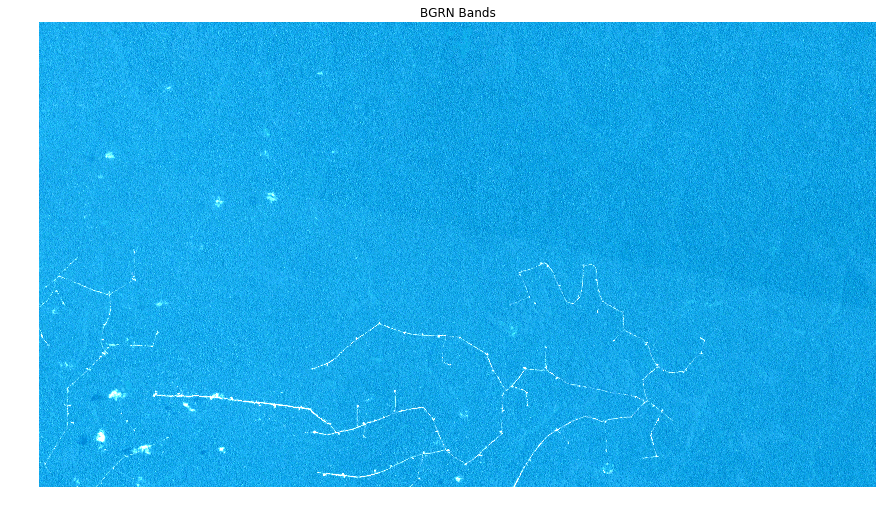

In [11]:
visualize_4band(load_4band(image_file))

## Texture Analysis of Scene

In this section, we create features from the OrthoTile scene that will be used to classify pixels in the scene as forest or non-forest. 

In this section, we perform texture analysis of the scene to create texture features which will aid in classifying pixels as forest or non-forest. Looking at the scene above, we can see that texture information could be very helpful in differentiating the two classes. Texture analysis is performed on a single band. For simplicity, here we will focus on the green band, which is pretty responsive to forest/non-forest.

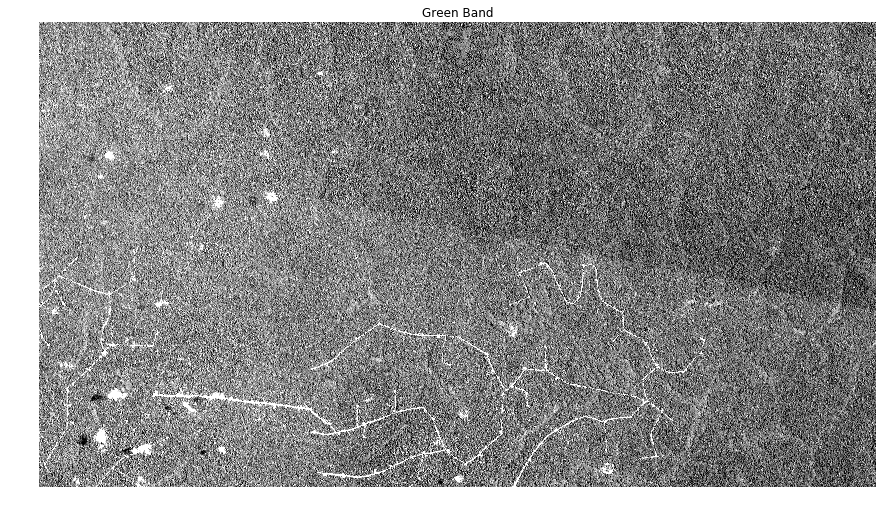

In [12]:
def load_green_band(filename):
    bgrn_bands = load_4band(filename)
    green_band = bgrn_bands[1]
    return green_band

def visualize_single_band(band, title='Single-band image', figsize=(15, 15)):
    if isinstance(band, np.ndarray):
        band = np.ma.array(band, mask=None)
    visual.plot_image(3 * [band], title=title, figsize=figsize)
    
    
visualize_single_band(load_green_band(image_file), title='Green Band')

The first step in texture analysis is finding the edges. We use [canny edge detection](http://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.canny) for this.

Because our image is in radiance, which is mostly consistent across images (there is some variation due to sun angle and earth-sun distance), we do not want to normalize it before edge detection. We just set our own thresholds for edge detection. This will ensure that edge detection is consistent across images (i.e. the presence of clouds won't be a factor).

To aid in visualization, we will zoom into the 1000x1000 pixel box in the lower-right corner of the image.

In [13]:
green_band_lr = load_green_band(image_file)[-1000:,:1000]

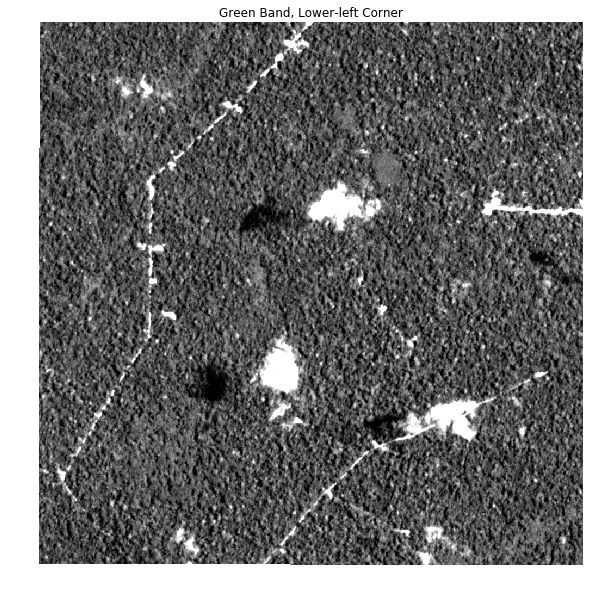

In [14]:
visualize_single_band(green_band_lr, title='Green Band, Lower-left Corner', figsize=(10, 10))

First we perform edge detection using the canny edge detection algorithm.

0 seconds


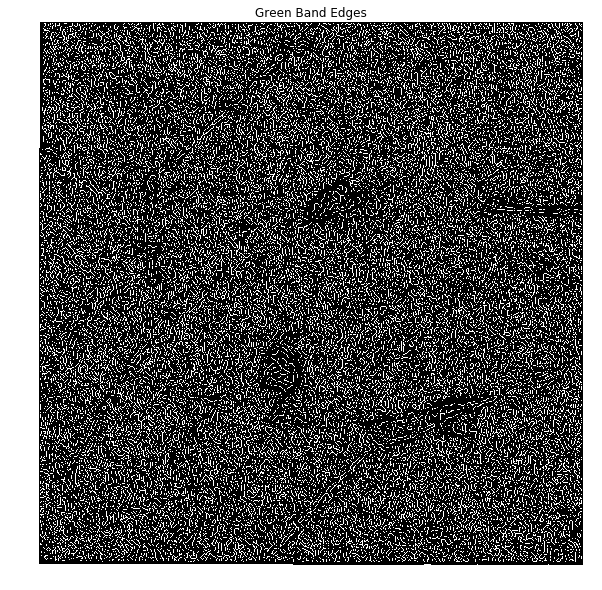

In [15]:
with Timer():
    edges1 = np.ma.array(feature.canny(green_band_lr,
                                       low_threshold=0.0, high_threshold=0.01,
                                       sigma=2), mask=green_band_lr.mask)

visualize_single_band(edges1, title='Green Band Edges', figsize=(10, 10))

We can see the clouds (as round blobs) and the roads (as elongated blobs). But there is still an aweful lot of noise. So, we will blur the edge image. This is equivalent to down-sampling the spatial frequency. We are looking to differentiate low-frequency edge changes (non-forest feature such as a road) from high-frequency changes (forest feature). We will do this in two steps, using different blur sizes (called kernel size). First, we will just do a two-pixel blur, then we will do a six-pixel blur. The different blur sizes allow us to call out different-sized features. Smaller features will be found in the two-pixel blur, larger features will be found in the six-pixel blur.

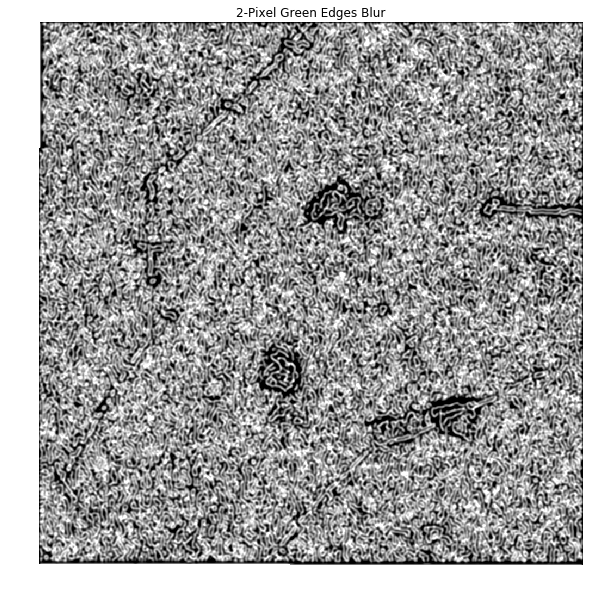

In [16]:
blurred = np.ma.array(filters.gaussian(edges1, sigma=2), mask=green_band_lr.mask)
visualize_single_band(blurred, title='2-Pixel Green Edges Blur', figsize=(10, 10))

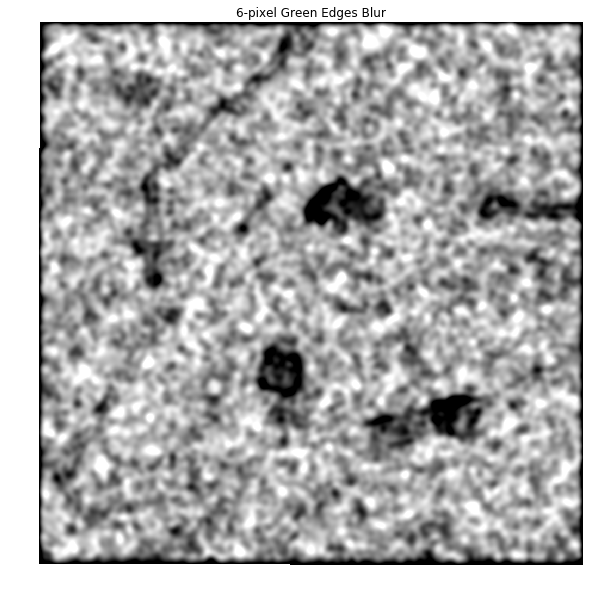

In [17]:
blurred2 = np.ma.array(filters.gaussian(edges1, sigma=6), mask=green_band_lr.mask)
visualize_single_band(blurred2, title='6-pixel Green Edges Blur', figsize=(10, 10))

Alright! These look pretty good. We notice that the roads and clouds show up in both of the blurred images, both the large image and the zoomed-in region. They show up in the large image because the down-sampling of the frequencies before display has meant that the down-sampling that occurs in the display process no longer causes the road/cloud features to be lost. They show up really well in the zoomed-in images because the down-sampling of the edges has done a good job of differentiating the forest from non-forest features. These blurred edges will serve as great texture features for classification.

Let's put this all together in one function.

In [18]:
def get_texture_features(bands):
    green_band = bands[1]
    edges1 = feature.canny(green_band, low_threshold=0.0, high_threshold=0.01, sigma=2)
    blurred = filters.gaussian(edges1, sigma=2)
    blurred2 = filters.gaussian(edges1, sigma=6)
    return [np.ma.array(texture_band, mask=green_band.mask)
            for texture_band in (blurred, blurred2)]

## Classify Pixels - Unsupervised (KMeans)

For our first attempt at classifying pixels into forest/non-forest, we will try one of the most simple classifiers, k-means. K-means is an unsupervised classification technique, which means we do not need any training data. We only need to know how many classes to find. To classify pixels, we will combine their Red, Green, Blue, and NIR spectral values with their texture (blurred edges) information into one feature vector, then we will feed that vector into a K-means classifier.

### Create feature dataset

To create the feature dataset, first we combine the 4 spectral bands (blue, green, red, nir) with the two texture bands. Then we scale them all to the range 0-1. Scaling is required because KMeans is an isotropic calculation, that is, `distance` between two data points is the same in all dimensions, regardless of the range of a given dimension.

In [ ]:
def get_feature_bands(image_file):
    spectral_bands = load_4band(image_file)
    texture_bands = get_texture_features(spectral_bands)
    return spectral_bands + texture_bands
    
def normalize(band):
    return (band-band.min())/(band.max()-band.min())

with Timer():
    feature_bands = get_feature_bands(image_file)
    n_samples = feature_bands[0].shape[0] * feature_bands[0].shape[1]
    print(n_samples)

Because there are over 10 thousand samples, we will use scikit-learn's [mini batch k means](https://scikit-learn.org/stable/modules/clustering.html#mini-batch-k-means) function to reduce computation.

In [20]:
def perc_masked(mask):
    return 100*(np.count_nonzero(mask))/mask.size

def num_valid(mask):
    return (mask.size - np.count_nonzero(mask))

def combine_masks(feature_bands):
    masks = [b.mask for b in feature_bands]
    total_mask = reduce(np.logical_or, masks)
    print('{} valid pixels ({}% masked)'.format(num_valid(total_mask),
                                                round(perc_masked(total_mask), 2)))
    return total_mask

def valid_pixels(band, mask):
    masked_band = np.ma.array(band, mask=mask)
    return masked_band.compressed()

def bands_to_X(feature_bands, mask):
    # X shape: (num_pixels, num_bands)
    all_valid_pixels = [valid_pixels(b, mask) for b in feature_bands]
    X = np.swapaxes(np.stack(all_valid_pixels), 0, 1)
    return X

def y_to_band(y, mask):
    band = np.ma.array(np.zeros(mask.shape), mask=mask)
    band[~band.mask] = y
    return band

def classify_kmeans(X):
    mbk = MiniBatchKMeans(n_clusters=2)
    
    with Timer():
        mbk.fit(X)
        
    with Timer():
        y_pred = mbk.predict(X)
        
    return y_pred

def kmeans_classification(image_file):
    kb_feature_bands = [normalize(b) for b in get_feature_bands(image_file)]
    total_mask = combine_masks(kb_feature_bands)
    X = bands_to_X(kb_feature_bands, total_mask)
    y_pred = classify_kmeans(X)
    y_band = y_to_band(y_pred, total_mask)
    return y_band

20000286 valid pixels (0.12% masked)
71 seconds
57 seconds
144 seconds


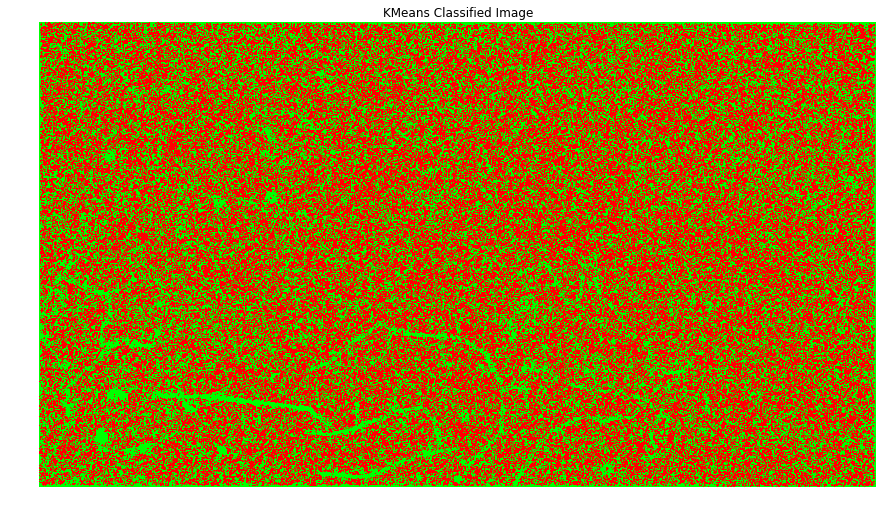

In [24]:
# separate the class numbers into rgb bands
def classified_band_to_rgb(classified_band):
    return [classified_band == n for n in [0,1,2]]

with Timer():
    y_band = kmeans_classification(image_file)
visual.plot_image(classified_band_to_rgb(y_band), title='KMeans Classified Image', figsize=(15, 15))

The roads do show up in this classified image, although there is also a lot of noise.

## Classify Pixels - Supervised (Random Forests)

To improve our classification results, we will use [Random forests](https://en.wikipedia.org/wiki/Random_forest) classification. We use the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Unlike k-means classification, random forest classification is supervised, that is, it requires a training set. 

To create the training set, we first save a version of one of the strip images as an 8-bit image so we can import it in [GIMP](https://www.gimp.org/). Then, in GIMP, we perform manual labeling of road and forest regions creating binary 'label images' for each class. We import these label images, and use them to create the training datasets from the original strip image. Finally, we use the training datasets to train the classifier.

### Create Label Image

We will perform labeling in GIMP. Gimp requires an 8-bit RGB image, which we generate here.

In [25]:
label_img = os.path.join('pre-data', 'roads.tif')

with rasterio.open(image_file, 'r') as src:
    profile = src.profile.copy()
    profile.update({'compress': 'lzw',
                    'dtype': rasterio.uint8,
                    'count': 3})
    
    bands = src.read()
    
    # scale to rgb 0-255, masked pixels are set to zero and band order is reversed
    bgr_bands = bands[:3]
    nodata = bands[3] == 0
    bgr_bands[:, nodata] == 0
    bgr_bands = bgr_bands / (float(bgr_bands.max()) / (2**8 - 1))
    
    rgb_bands = np.rint(bgr_bands[::-1]).astype(rasterio.uint8)
    
    with rasterio.open(label_img, 'w', **profile) as dst:
        dst.write(rgb_bands)

### Create Label Features from Label Images

Label images were created in GIMP and saved in the `pre-data` folder.

In this step, we load the label images, convert them to binary masks and apply them to the feature dataset to obtain two sets of data points: one set that contains features for the forest class, and another set that contains features for the road class.

In [26]:
forest_img = os.path.join('pre-data', 'forestroad_forest.tif')
road_img = os.path.join('pre-data', 'forestroad_road.tif')

In [27]:
def get_label_mask(image_filename):
    with rasterio.open(image_filename, 'r') as src:
        band = src.read(1)
        label_data = band == 255 # valid data in white regions
        label_mask = ~label_data # mask True (masked) for not valid data
    return label_mask

def get_unmasked_count(mask):
    return np.size(mask) - np.count_nonzero(mask)

forest_mask = get_label_mask(forest_img)
print(get_unmasked_count(forest_mask))
road_mask = get_label_mask(road_img)
print(get_unmasked_count(road_mask))

/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:240: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s = DatasetReader(fp, driver=driver, **kwargs)


6652509
17219


In [30]:
# combine the label masks with the valid data mask and then create X dataset for each label
feature_bands = get_feature_bands(image_file)
total_mask = combine_masks(feature_bands)

total_forest_mask = np.logical_or(total_mask, forest_mask)
print('{} valid pixels ({}% masked)'.format(num_valid(total_forest_mask),
                                            round(perc_masked(total_forest_mask), 2)))
X_forest = bands_to_X(feature_bands, total_forest_mask)

total_road_mask = np.logical_or(total_mask, road_mask)
print('{} valid pixels ({}% masked)'.format(num_valid(total_road_mask),
                                            round(perc_masked(total_road_mask), 2)))
X_road = bands_to_X(feature_bands, total_road_mask)

20000286 valid pixels (0.12% masked)
6652509 valid pixels (66.78% masked)
17219 valid pixels (99.91% masked)


### Prepare Training Datasets

In this step, we create the training datasets, X (features) and y (class), in the format used by scikit-learn.

As a part of this step, we use random sampling to create same-size samples of labeled pixels so we have a balanced training dataset.

In [31]:
def sample_pixels(pixels, sample_size):
    if pixels.shape[0] > sample_size:
        pixel_sample = pixels.copy()
        np.random.shuffle(pixel_sample)
        pixel_sample = pixel_sample[:sample_size]
    else:
        pixel_sample = pixels
    return pixel_sample
    
def make_same_size_samples(list_of_X, size_percent=100):
    # X: array of dim (num_pixels, num_classified_bands)
    sample_len = min([p.shape[0] for p in list_of_X])

    # only return size_percent number of pixels in the sample
    if size_percent < 100 and size_percent > 0:
        sample_len = round(sample_len * size_percent/100.0)
    
    return [sample_pixels(p, sample_len) for p in list_of_X]

[X_forest_sample, X_road_sample] = \
    make_same_size_samples([X_forest, X_road], size_percent=10)

print(X_forest_sample.shape)
print(X_road_sample.shape)

(1722, 6)
(1722, 6)


In [32]:
forest_label_value = 0
road_label_value = 1
X_training = np.concatenate((X_forest_sample, X_road_sample), axis=0)
y_training = np.array(X_forest_sample.shape[0] * [forest_label_value] + \
                      X_road_sample.shape[0] * [road_label_value])
    
print(X_training.shape)
print(y_training.shape)

(3444, 6)
(3444,)


In [33]:
# save to file system
training_data_file = os.path.join('pre-data', 'classification_training.npz')
np.savez(training_data_file, X=X_training, y=y_training)

### Train Classifier 

In [34]:
# load training data
def load_training_data(training_data_file):
    npzfile = np.load(training_data_file)
    X_training = npzfile['X']
    y_training = npzfile['y']
    return X_training, y_training

X_training, y_training = load_training_data(training_data_file)

In [35]:
def classify_forest(image_file, X_training, y_training):
    clf = RandomForestClassifier()
    
    with Timer():
        clf.fit(X_training, y_training)
    
    # for random forest classification, no normalization of the features is required
    feature_bands = get_feature_bands(image_file)
    total_mask = combine_masks(feature_bands)
    X_rf = bands_to_X(feature_bands, total_mask)
    
    with Timer():
        y_pred_rf = clf.predict(X_rf)

    y_band_rf = y_to_band(y_pred_rf, total_mask)
    return y_band_rf

with Timer():
    y_band_rf = classify_forest(image_file, X_training, y_training)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
20000286 valid pixels (0.12% masked)
8 seconds
23 seconds


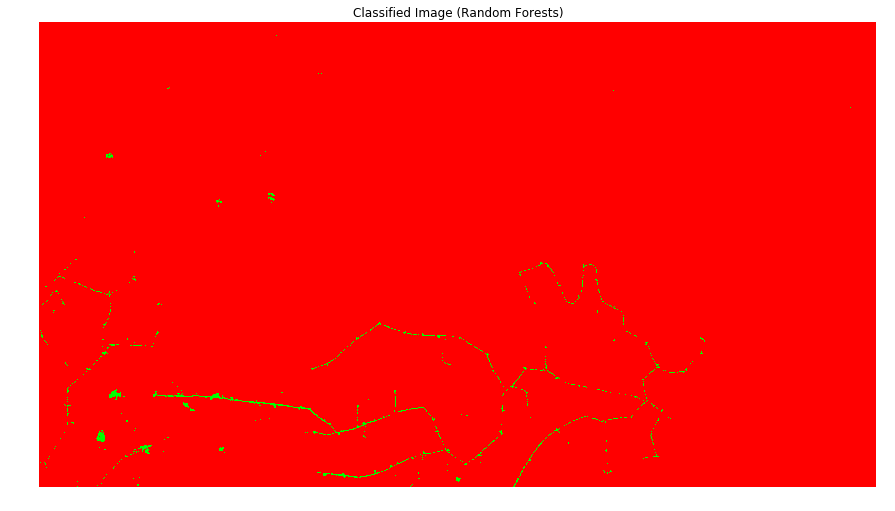

In [36]:
visual.plot_image(classified_band_to_rgb(y_band_rf),
                  title='Classified Image (Random Forests)',
                  figsize=(15, 15))

Look at that! The classified image shows both clouds and roads as non-forest and there is very little noise in the forest region.

There you go, pretty great results classifying an OrthoTile AOI strip scene into forest / non-forest in 18 seconds. Hard to beat that!